<a href="https://colab.research.google.com/github/MUMADE-TADM/s1_python-gercevas/blob/main/TADM2022_S04_Razonamiento_Aproximado_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vamos a operar de diferentes maneras con los préstamos de nuestro banco, en concreto vamos a intentar crear clasificadores para que dadas unas variables nos den la probabilidad o el rating de darle un préstamo a un cliente

## Carga de Datos

In [1]:
!gdown --id 1Osmr7qVN0NMuqYxvLesNn7H4nqPCVbsU

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Osmr7qVN0NMuqYxvLesNn7H4nqPCVbsU
To: /content/data_berka.db
100% 70.2M/70.2M [00:00<00:00, 83.3MB/s]


1. Cargamos la extensión sql

In [2]:
%load_ext sql

2. Nos conectamos con la base de datos

In [3]:
%sql sqlite:///data_berka.db

'Connected: @data_berka.db'

> Datos de préstamos ya finalizados con su estado final, incluyendo datos del distrito, etc.

¿Cuántos préstamos hay por cada estado (status)?

In [4]:
%%sql
SELECT status, count(*) as total
FROM loan
GROUP BY status
ORDER BY total DESC 



 * sqlite:///data_berka.db
Done.


status,total
C,403
A,203
D,45
B,31


Vamos a empezar obteniendo los datos de los préstamos ya finalizados. Van a ser nuestros datos de entrenamiento. Por lo que seleccionaremos únicamente aquellos préstamos en status 'A' o 'B'. 

Con una sentencia CASE vamos a poner los prestamos finalizados bien a 1 y los que no finalizaron bien a 0. 

Sintaxis de uso de [INNER JOIN](https://www.sqlitetutorial.net/sqlite-inner-join/) para establecer joins entre tablas

In [5]:
%%sql loans_train << SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13,
  CASE status WHEN 'A' THEN 1
              WHEN 'B' THEN 0
  END label
  FROM LOAN l, ACCOUNT a INNER JOIN DISTRICT d on a.district_id = d.A1 
  WHERE l.account_id = a.account_id and l.status in ("A", "B")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_train


3. Obtenemos el DataFrame

In [6]:
df_train = loans_train.DataFrame()
df_train.head()

,year,amount,duration,payments,A11,A13,label
0,93,96396,12,8033,9650,3.67,0
1,93,165960,36,4610,8369,2.31,1
2,93,127080,60,2118,8390,2.89,1
3,93,105804,36,2939,8754,4.31,1
4,93,274740,60,4579,12541,0.43,1


In [7]:
df_train.shape

(234, 7)

Para la parte de *test* lo que vamos a extraer de la Base de Datos son los préstamos que están en ejecución (`status in ("C", "D")`) con los mismos campos que en la consulta anterior.

In [8]:
%%sql loans_test << SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13,
  CASE status WHEN 'C' THEN 1
              WHEN 'D' THEN 0
  END label
  FROM LOAN l, ACCOUNT a INNER JOIN DISTRICT d on a.district_id = d.A1 
  WHERE l.account_id = a.account_id and l.status in ("C", "D")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_test


**Ejercicio**: Añadir la edad del cliente propietario de la cuenta del prestamo y algún campo de datos demográficos adicionales


In [10]:
%%sql 
SELECT substr(l.date,0,3) year, 99-substr(c.birth_number,0,3) age, amount, duration, payments, A11, A13, 
CASE status WHEN 'A' THEN 1 
            WHEN 'B' THEN 0
END label
FROM LOAN l, ACCOUNT a, DISTRICT d, CLIENT c, DISPOSITION disp
WHERE l.account_id = a.account_id
AND a.account_id = disp.account_id
AND disp.client_id = c.client_id
AND c.district_id = d.a1
AND l.status in ("A", "B")
LIMIT 15

 * sqlite:///data_berka.db
Done.


year,age,amount,duration,payments,A11,A13,label
94,54,80952,24,3373,12541,0.43,1
94,59,80952,24,3373,12541,0.43,1
96,60,30276,12,2523,9104,2.07,0
97,37,30276,12,2523,9893,4.72,1
96,55,165960,24,6915,8427,1.54,1
97,57,102876,12,8573,10673,5.44,1
97,63,102876,12,8573,10673,5.44,1
96,54,88440,12,7370,9317,7.07,1
96,61,88440,12,7370,9317,7.07,1
94,60,104808,12,8734,8512,4.12,1


In [11]:
df_test = loans_test.DataFrame()
df_test.head()

,year,amount,duration,payments,A11,A13,label
0,94,253200,60,4220,9893,4.72,1
1,94,300660,60,5011,9317,7.07,1
2,94,167100,60,2785,8544,1.86,1
3,94,149340,60,2489,8254,3.76,1
4,94,89040,60,1484,8909,5.56,1


4. División de los datos en entrenamiento y test

`features` es una variable de tipo lista que me almacena los nombres de las características que me sirven como **entrada**

In [12]:
features = ["year", "amount", "duration", "payments","A11", "A13"]

* train (creación del modelo) : datos de préstamos ya finalizados
* test (evaluación del modelo): datos de préstamos en ejecución

In [13]:
X_train = df_train[features]
y_train = df_train["label"]

X_test = df_test[features]
y_test = df_test["label"]


5. Normalizarlos puede ser una buena medida para obtener mejores resultados.
Para ello vamos a utilizar el [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

El centrado y el escalado se realizan de forma independiente en cada característica, calculando las estadísticas pertinentes en las muestras del **conjunto de entrenamiento**. La media y la desviación estándar se almacenan para utilizarlas en datos posteriores mediante una **transformación**.

Mas información sobre normalización en el siguiente [enlace](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler)


In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# calculo de los factores de centrado y escalado
scaler.fit(X_train) 
# transformación
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Aplicamos un modelo [NaiveBayes](https://scikit-learn.org/stable/modules/naive_bayes.html?highlight=naive+bayes) para construir un clasificador de préstamos

In [15]:
from sklearn.naive_bayes import GaussianNB #, MultinomialNB, BernoulliNB, ComplementNB

gnb = GaussianNB()
clf = gnb.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test.shape[0], (y_test != y_pred).sum()))


Número de préstamos clasificados erroneamente 448 de un total de  123


Para ver que resultados tenemos sobre la colección de `test` utilizamos en primer lugar el informe de los resultados [`classification report`](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report)

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, labels=clf.classes_))

              precision    recall  f1-score   support

           0       0.20      0.60      0.31        45
           1       0.94      0.74      0.83       403

    accuracy                           0.73       448
   macro avg       0.57      0.67      0.57       448
weighted avg       0.87      0.73      0.78       448



Y la [matriz de confusión](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)

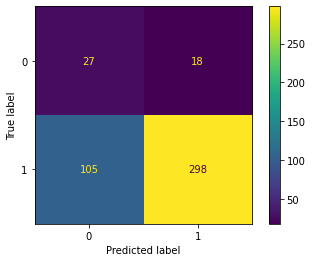

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels= clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

**Ejercicios**

Plantear el clasificador de préstamos añadiendo datos de otras tablas de la base de datos, u otros campos de las mismas tablas (edad del cliente, etc).

Otras transformaciones: [Discretización](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-discretization) y utilización de otros clasificadores NB

Se añaden las variables age, criminality range para los prestamos de status A y B, año del préstamo obtenido

In [22]:
%%sql 
select substr(lo.date,0,3) year_concesion,amount, duration, payments, A11, A13, 99-substr(cl.birth_number,0,3) year , a16 criminality,
CASE status WHEN 'A' THEN 1 
              WHEN 'B' THEN 0
END label
from LOAN lo, ACCOUNT ac, DISTRICT dist, CLIENT cl, DISPOSITION disp
where lo.account_id = ac.account_id
and ac.account_id = disp.account_id
and disp.client_id = cl.client_id
and cl.district_id = dist.a1
and lo.status in ("A", "B")
limit 5

 * sqlite:///data_berka.db
Done.


year_concesion,amount,duration,payments,A11,A13,year,criminality,label
94,80952,24,3373,12541,0.43,54,99107,1
94,80952,24,3373,12541,0.43,59,99107,1
96,30276,12,2523,9104,2.07,60,2354,0
97,30276,12,2523,9893,4.72,37,5887,1
96,165960,24,6915,8427,1.54,55,1913,1


In [20]:
%%sql loans_train_2 << select substr(lo.date,0,3) year_concesion, amount, duration, payments, A11, A13, 99-substr(cl.birth_number,0,3) year ,lo.date, a16 criminality,
  CASE status WHEN 'A' THEN 1 
              WHEN 'B' THEN 0
  END label

  FROM LOAN lo inner join ACCOUNT ac on lo.account_id = ac.account_id
             inner join DISPOSITION disp on ac.account_id = disp.account_id
             inner join CLIENT cl on disp.client_id = cl.client_id
             inner join DISTRICT dist on cl.district_id = dist.a1
  Where lo.status in ("A", "B")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_train_2


In [21]:
df_train_2 = loans_train_2.DataFrame()
df_train_2.head()

,year_concesion,amount,duration,payments,A11,A13,year,date,criminality,label
0,94,80952,24,3373,12541,0.43,54,940105,99107,1
1,94,80952,24,3373,12541,0.43,59,940105,99107,1
2,96,30276,12,2523,9104,2.07,60,960429,2354,0
3,97,30276,12,2523,9893,4.72,37,971208,5887,1
4,96,165960,24,6915,8427,1.54,55,960502,1913,1


In [23]:
df_train_2.shape

(289, 10)

Ahora lo mismo pero con C y D

In [26]:
%%sql loans_test_2 << select substr(lo.date,0,3) year_concesion, amount, duration, payments, A11, A13, 99-substr(cl.birth_number,0,3) year ,lo.date, a16 criminality,
  CASE status WHEN 'C' THEN 1 
              WHEN 'D' THEN 0
  END label

  FROM LOAN lo inner join ACCOUNT ac on lo.account_id = ac.account_id
             inner join DISPOSITION disp on ac.account_id = disp.account_id
             inner join CLIENT cl on disp.client_id = cl.client_id
             inner join DISTRICT dist on cl.district_id = dist.a1
  Where lo.status in ("C", "D")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_test_2


In [27]:
df_test_2 = loans_test_2.DataFrame()
df_test_2.head()

,year_concesion,amount,duration,payments,A11,A13,year,date,criminality,label
0,98,318480,60,5308,8547,3.64,47,981014,1542,0
1,98,110736,48,2307,8402,3.98,59,980419,1099,1
2,97,265320,36,7370,8254,3.76,32,971206,2325,0
3,98,352704,48,7348,9104,2.07,49,981205,2354,1
4,97,162576,36,4516,9198,4.28,46,970908,6132,1


In [28]:
df_test_2.shape

(538, 10)

Ahora se procederá a dividar en datos de prueba y entrenamiento

In [29]:
features = ["year_concesion", "amount", "duration", "A11", "A13", "year", "date", "criminality"]

In [30]:
X_train_2 = df_train_2[features]
y_train_2 = df_train_2["label"]

X_test_2 = df_test_2[features]
y_test_2 = df_test_2["label"]

In [31]:
scaler = StandardScaler()
# calculo de los factores de centrado y escalado
scaler.fit(X_train_2) 
# transformación
X_train_2 = scaler.transform(X_train_2)
X_test_2 = scaler.transform(X_test_2)

In [33]:
gnb = GaussianNB()
clf = gnb.fit(X_train_2, y_train_2)
y_pred = clf.predict(X_test_2)
print("Préstamos mal clasificados %d de un total de  %d"  % (X_test_2.shape[0], (y_test_2 != y_pred).sum()))


Préstamos mal clasificados 538 de un total de  149


In [35]:
print(classification_report(y_test_2, y_pred, labels=clf.classes_))

              precision    recall  f1-score   support

           0       0.16      0.53      0.24        45
           1       0.95      0.74      0.83       493

    accuracy                           0.72       538
   macro avg       0.55      0.64      0.54       538
weighted avg       0.88      0.72      0.78       538



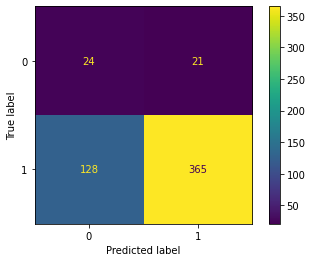

In [36]:
cm = confusion_matrix(y_test_2, y_pred, labels= clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

La probabilidad de acierto del modelo es de 365+24=389
389/538= 0,72 -> 72%